In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#some of blocks below are not used.
# Data manipulation
import numpy as np
import pandas as pd
import csv
# import vgg_pytorch as vp
# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys
import dlib
import cv2
from glob import glob
from PIL import Image



np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=16
NUMBER_EPOCHS=10
IMG_SIZE=224

pathDir  = 'drive/MyDrive/Dataset_Actor/Kinface-Act/'
pathDir =   'drive/MyDrive/Dataset_Ignoti/'

In [ ]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = vgg16(pretrained=True)# wide_resnet50_2(pretrained=True)##vp.VGG.from_pretrained('vgg16')#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        #self.ccn1.classifier =  nn.Linear(100*100, )
        # #Freeze training for all layers
        for param in self.cnn1.features.parameters():
          param.require_grad = False



        #Newly created modules have require_grad=True by default
        num_features = self.cnn1.classifier[3].in_features
        features = list(self.cnn1.classifier.children())[:-3] # Remove last layer

        self.cnn1.classifier = nn.Sequential(*features) # Replace the model classifier
        # features.extend([nn.Linear(num_features, 1000)]) # Add our layer with 4 outputs
        # features.extend([nn.ReLU(inplace=True)])
        # features.extend([nn.Dropout()]) # Add our layer with 4 outputs
        # self.cnn1.classifier[3].out_features = 5
        self.new_classifier = features
        # self.pool =  nn.MaxPool2d
        self.fc1 = nn.Linear(num_features*2, 1024)
        self.fc2 = nn.Linear(1024, 500)
        self.fc3 = nn.Linear(500, 5)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        # self.cnn1.classifier = nn.Sequential(*self.new_classifier).cuda()
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        #output1 = F.max_pool2d(output1,kernel_size=3)
        #output1 = self.pool(2)(output1)
        #output1 = torch.cat((output1,output1),1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        # output2 = self.pool(2)(output2)
        #output2 = torch.cat((output2,output2),1)
        substract_out = torch.subtract(output1,output2)
        diffal2 = torch.multiply(substract_out,substract_out)
        molt = torch.multiply(output1,output2)
        output1al2 = torch.multiply(output1,output1)
        output2al2 = torch.multiply(output2,output2)
        diffdei2 = torch.abs(torch.subtract(output1al2,output2al2))

        output = torch.cat((diffal2, molt),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
# class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         self.cnn1 = vgg16(pretrained=True)# wide_resnet50_2(pretrained=True)##vp.VGG.from_pretrained('vgg16')#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
#         #self.ccn1.classifier =  nn.Linear(100*100, )
#         # #Freeze training for all layers
#         for param in self.cnn1.features.parameters():
#           param.require_grad = False
        
#         for param in self.cnn1.classifier.parameters():
#           param.require_grad = False



#         #Newly created modules have require_grad=True by default
#         num_features = self.cnn1.classifier[3].in_features
#         features = list(self.cnn1.classifier.children())[:-3] # Remove last layer
        
#         self.cnn1.classifier = nn.Sequential(*features) # Replace the model classifier
#         # features.extend([nn.Linear(num_features, 1000)]) # Add our layer with 4 outputs
#         # features.extend([nn.ReLU(inplace=True)])
#         # features.extend([nn.Dropout()]) # Add our layer with 4 outputs
#         # self.cnn1.classifier[3].out_features = 5
#         self.new_classifier = features
#         # self.pool =  nn.MaxPool2d
#         self.fc1 = nn.Linear(num_features*3, 1024)
#         self.fc2 = nn.Linear(1024, 500)
#         self.fc3 = nn.Linear(500, 4)


#     def forward(self, input1, input2):#did not know how to let two resnet share the same param.
#         # self.cnn1.classifier = nn.Sequential(*self.new_classifier).cuda()
#         output1 = self.cnn1(input1)
#         output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
#         #output1 = F.max_pool2d(output1,kernel_size=3)
#         #output1 = self.pool(2)(output1)
#         #output1 = torch.cat((output1,output1),1)
#         output2 = self.cnn1(input2)
#         output2 = output2.view(output2.size()[0], -1)
#         # output2 = self.pool(2)(output2)
#         #output2 = torch.cat((output2,output2),1)
#         substract_out = torch.subtract(output1,output2)
#         diffal2 = torch.multiply(substract_out,substract_out)
#         molt = torch.multiply(output1,output2)
#         output1al2 = torch.multiply(output1,output1)
#         output2al2 = torch.multiply(output2,output2)
#         diffdei2 = torch.abs(torch.subtract(output1al2,output2al2))
#         output = torch.cat((diffal2, molt,diffdei2),1)
#         output = F.relu(self.fc1(output))
#         output = F.relu(self.fc2(output))
#         output = self.fc3(output)
#         return output

In [ ]:
def Trasform(lista):
  listatemp = []
  for l in lista:
      listatemp.append(labelCM[l])
  return listatemp

def converti(label):
      if label == 0:
        return "father-dau"
      elif label == 1:
        return "father-son"
      elif label == 2:
        return "mother-dau"
      elif label == 3:
        return "mother-son"
      else:
        return "Non-Kinship"

In [ ]:
df0 =  pd.read_csv(pathDir+"fd.csv",names=["p1", "p2","Label"])
df1 =  pd.read_csv(pathDir+"fs.csv",names=["p1", "p2","Label"])
df2 =  pd.read_csv(pathDir+"md.csv",names=["p1", "p2","Label"])
df3 =  pd.read_csv(pathDir+"ms.csv",names=["p1", "p2","Label"])
dfFinal = pd.concat([df0,df1,df2,df3])
len(dfFinal)

23

In [ ]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self, dataFrame, transform=None):
        self.dataFrame = dataFrame #choose either train or val dataset to use
        self.transform = transform
   
        
    def __getitem__(self,index):
        img0_info = self.dataFrame.iloc[index]["p1"] #for each relationship in train_relationships.csv, the first img comes from first row, and the second is either specially choosed related person or randomly choosed non-related person
        img1_info = self.dataFrame.iloc[index]["p2"]
        label_number = self.dataFrame.iloc[index]["Label"] 
        label_desc = converti(label_number)
        if label_desc == 'Non-Kinship':
          if img0_info[0:2] == 'fd':
             img0_path =pathDir+"father-dau"+"/"+img0_info
             img1_path =pathDir+"father-dau"+"/"+img1_info
          if img0_info[0:2] == 'fs':
             img0_path =pathDir+"father-son"+"/"+img0_info
             img1_path =pathDir+"father-son"+"/"+img1_info
          if img0_info[0:2] == 'md':
             img0_path =pathDir+"mother-dau"+"/"+img0_info
             img1_path =pathDir+"mother-dau"+"/"+img1_info
             
          if img0_info[0:2] == 'ms':
             img0_path =pathDir+"mother-son"+"/"+img0_info
             img1_path =pathDir+"mother-son"+"/"+img1_info
        else:
          img0_path =pathDir+label_desc+"/"+img0_info
          img1_path =pathDir+label_desc+"/"+img1_info        
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , label_number #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.dataFrame)#essential for choose the num of data in one epoch

In [ ]:
pathModel = '/content/drive/My Drive/input/Prova1simple_network-Kinface2_12-06-No-abs.h5'

In [ ]:
# pathModel = '/content/drive/MyDrive/input/Prova1simple_network-Kinface2_12-06-4ClassiSIabs3FEParamBlocc.h5'

In [ ]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(pathModel))

<All keys matched successfully>

In [ ]:
testset = trainingDataset(dataFrame=dfFinal,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[2 1 0 2 0]
 [0 4 0 1 0]
 [1 0 2 5 0]
 [0 3 0 2 0]
 [0 0 0 0 0]]


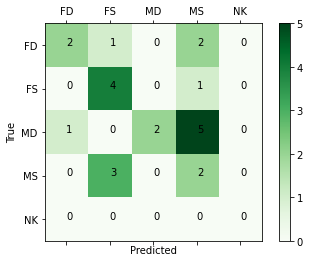

0.4
0.8
0.25
0.4
nan
43.47826086956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
predictions=[]
lb =[]
with torch.no_grad():
    for data in testloader:
        img0, img1,label = data
        img0, img1,label = img0.cuda(), img1.cuda(),label.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy())#taking care of here, the output data format is important for transfer
        lb.append(label.cpu().numpy())

flat_list = [item for sublist in lb for item in sublist]
flat_predictions = [item for sublist in predictions for item in sublist]
correct = 0
for i in range(0,len(flat_list)):
    if flat_list[i] == flat_predictions[i]:
      correct+=1
  
labelCM = ["FD", "FS","MD","MS","NK"]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Trasform(flat_list),Trasform(flat_predictions),labelCM)
print(cm)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
for i in range(len(cm[0])):
  for j in range(len(cm[0])):
    ax.text(j, i, format(cm[i][j], "d"))
ax.set_xticklabels([''] + labelCM)
ax.set_yticklabels([''] + labelCM)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.set_cmap('Greens')
plt.show()

print(cm[0][0]/(cm[0].sum()))
print(cm[1][1]/(cm[1].sum()))
print(cm[2][2]/(cm[2].sum()))
print(cm[3][3]/(cm[3].sum()))
print(cm[4][4]/(cm[4].sum()))
print(correct/23*100)